In [1]:
'''
Pre Train - retrain all the parameters of the network(ideally done when there is a large dataset)
Fine tune - update all the weights afterwards is called fine tuning 
'''

'\nPre Train - retrain all the parameters of the network(ideally done when there is a large dataset)\nFine tune - update all the weights afterwards is called fine tuning \n'

## Densenet on Cats & Dogs Dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time

### Data Preparation

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


2022-04-11 11:44:49.582690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 11:44:49.668524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 11:44:49.669307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 11:44:49.672589: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


2022-04-11 11:44:52.063633: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


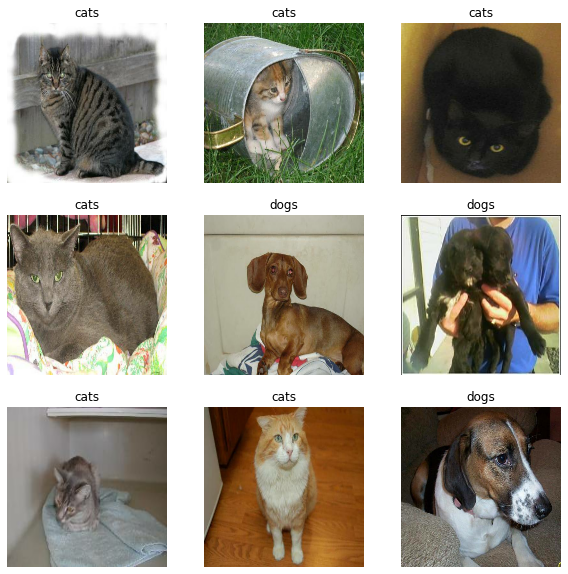

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<p>
    As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.
</p>

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
# Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [9]:
'''
Data Augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by
applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping.
This helps expose the model to different aspects of the training data and reduce overfitting.
'''
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

'''
Note
Note: These layers are active only during training, when you call Model.fit.
They are inactive when the model is used in inference mode in Model.evaluate or Model.fit.
'''

'\nNote\nNote: These layers are active only during training, when you call Model.fit.\nThey are inactive when the model is used in inference mode in Model.evaluate or Model.fit.\n'

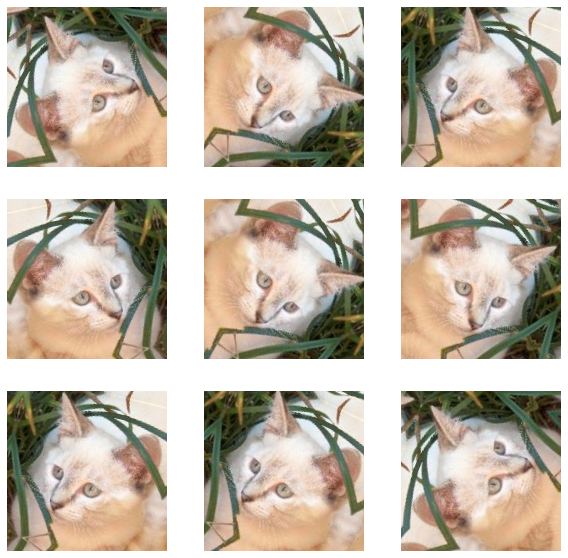

In [10]:
# Let's repeatedly apply these layers to the same image and see the result.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
# rescale pixel values
densenet_preprocess_input = tf.keras.applications.densenet.preprocess_input
rescale = tf.keras.layers.Rescaling(1./255.0, offset=-1)

### Create the base model from the pre-trained convnets

<ul>
  <li>Creating the base model from the Densenet121. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.</li>
  <li>First, we need to pick which layer of Densene121 we will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.</li>
  <li>First, instantiating a Densenet121 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.</li>
</ul>

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
densenet_base = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)

29097984/29084464 [==============================] - 0s 0us/step


In [13]:
'''
This feature extractor converts each 160x160x3 image into a 5x5x1024 block of features.
Let's see what it does to an example batch of images
'''

image_batch, label_batch = next(iter(train_dataset))
densenet_feature_batch = densenet_base(image_batch)
print(densenet_feature_batch.shape)

2022-04-11 11:44:58.333475: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 5, 5, 1024)


In [14]:
'''
Feature extraction
In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor.
Additionally, we add a classifier on top of it and train the top-level classifier.

Freeze the convolutional base
It is important to freeze the convolutional base before we compile and train the model.
Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.
Densenet121 has many layers, so setting the entire model's trainable flag to False will freeze all of them.
'''

densenet_base.trainable = False

In [15]:
# model summary
densenet_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [16]:
'''
Adding a classification head:
To generate predictions from the block of features, average over the spatial 5x5 spatial locations,
using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1024-element vector per image.
'''
densenet_global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
densenet_feature_batch_average = densenet_global_average_layer(densenet_feature_batch)
print(densenet_feature_batch_average.shape)

(32, 1024)


In [17]:
'''
Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.
We don't need an activation function here because this prediction will be treated as a logit,
or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.
'''
densenet_prediction_layer = tf.keras.layers.Dense(1)
densenet_prediction_batch = densenet_prediction_layer(densenet_feature_batch_average)
print(densenet_prediction_batch.shape)

(32, 1)


In [18]:
'''
Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the
Keras Functional API.As previously mentioned, use training=False as our model contains a BatchNormalization layer.
'''
densenet_inputs = tf.keras.Input(shape=(160, 160, 3))
densenet_x = data_augmentation(densenet_inputs)
densenet_x = densenet_preprocess_input(densenet_x)
densenet_x = densenet_base(densenet_x, training=False)
densenet_x = densenet_global_average_layer(densenet_x)
densenet_x = tf.keras.layers.Dropout(0.2)(densenet_x)
densenet_outputs = densenet_prediction_layer(densenet_x)
densenet_model = tf.keras.Model(densenet_inputs, densenet_outputs)

### Compile the model

In [19]:
'''
Compile the model before training it. Since there are two classes,
use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.
'''
densenet_base_learning_rate = 0.0001
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=densenet_base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
densenet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 5, 5, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0     

In [21]:
'''
Trainable parameters are divided between two tf.Variable objects, the weights and biases.
'''
len(densenet_model.trainable_variables)

2

### Train the model

In [22]:
%%time
initial_epochs = 10

densenet_loss0, densenet_accuracy0 = densenet_model.evaluate(validation_dataset)

26/26 [==============================] - 5s 52ms/step - loss: 1.1555 - accuracy: 0.3540
CPU times: user 5.61 s, sys: 249 ms, total: 5.86 s
Wall time: 4.79 s


In [23]:
print("initial loss: {:.2f}".format(densenet_loss0))
print("initial accuracy: {:.2f}".format(densenet_accuracy0))

initial loss: 1.16
initial accuracy: 0.35


In [24]:
%%time
densenet_history = densenet_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 11s 80ms/step - loss: 1.1086 - accuracy: 0.4160 - val_loss: 0.7992 - val_accuracy: 0.5520
Epoch 2/10
63/63 [==============================] - 4s 66ms/step - loss: 0.8131 - accuracy: 0.5645 - val_loss: 0.5668 - val_accuracy: 0.7153
Epoch 3/10
63/63 [==============================] - 4s 68ms/step - loss: 0.6773 - accuracy: 0.6600 - val_loss: 0.4350 - val_accuracy: 0.7933
Epoch 4/10
63/63 [==============================] - 4s 68ms/step - loss: 0.5408 - accuracy: 0.7350 - val_loss: 0.3363 - val_accuracy: 0.8502
Epoch 5/10
63/63 [==============================] - 5s 69ms/step - loss: 0.4608 - accuracy: 0.7805 - val_loss: 0.2787 - val_accuracy: 0.8812
Epoch 6/10
63/63 [==============================] - 5s 69ms/step - loss: 0.3944 - accuracy: 0.8190 - val_loss: 0.2291 - val_accuracy: 0.9047
Epoch 7/10
63/63 [==============================] - 4s 68ms/step - loss: 0.3578 - accuracy: 0.8430 - val_loss: 0.1961 - val_accuracy: 0.9208
Epoch 8/10
6

### Learning Curves

<p>
Let's take a look at the learning curves of the training and validation accuracy/loss when using the Densenet base model as a fixed feature extractor.
</p>

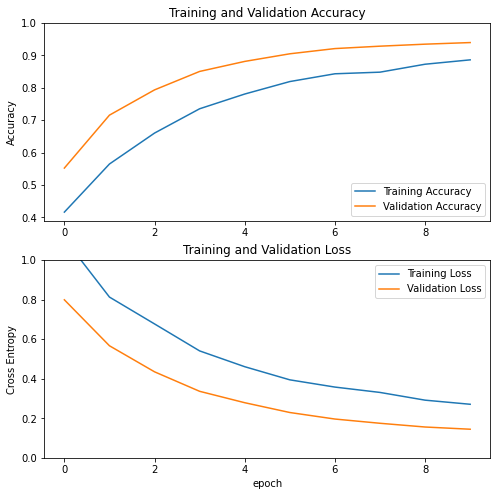

In [25]:
densenet_acc = densenet_history.history['accuracy']
densenet_val_acc = densenet_history.history['val_accuracy']

densenet_loss = densenet_history.history['loss']
densenet_val_loss = densenet_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(densenet_acc, label='Training Accuracy')
plt.plot(densenet_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(densenet_loss, label='Training Loss')
plt.plot(densenet_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuninng

In [26]:
'''
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model.
The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the
pre-trained model alongside the training of the classifier you added. The training process will force the weights
to be tuned from generic feature maps to features associated specifically with the dataset.

Note:
This should only be attempted after you have trained the top-level classifier with the pre-trained model set to
non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt totrain all layers
jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier)
and pre-trained model will forget what it has learned.
'''

'\nIn the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model.\nThe weights of the pre-trained network were not updated during training.\n\nOne way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the\npre-trained model alongside the training of the classifier you added. The training process will force the weights\nto be tuned from generic feature maps to features associated specifically with the dataset.\n\nNote:\nThis should only be attempted after you have trained the top-level classifier with the pre-trained model set to\nnon-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt totrain all layers\njointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier)\nand pre-trained model will forget what it has learned.\n'

In [27]:
'''
Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model.
In most convolutional networks, the higher up a layer is, the more specialized it is.
The first few layers learn very simple and generic features that generalize to almost all types of images.
As we go higher up, the features are increasingly more specific to the dataset on which the model was trained.
The goal of fine-tuning is to adapt these specialized features to work with the new dataset,
rather than overwrite the generic learning.
'''

'\nAlso, we should try to fine-tune a small number of top layers rather than the whole MobileNet model.\nIn most convolutional networks, the higher up a layer is, the more specialized it is.\nThe first few layers learn very simple and generic features that generalize to almost all types of images.\nAs we go higher up, the features are increasingly more specific to the dataset on which the model was trained.\nThe goal of fine-tuning is to adapt these specialized features to work with the new dataset,\nrather than overwrite the generic learning.\n'

### Un-freeze the top layers of the model

In [28]:
'''
All we need to do is unfreeze the base_model and set the bottom layers to be un-trainable.
Then, we should recompile the model (necessary for these changes to take effect), and resume training.
'''
densenet_base.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(densenet_base.layers))

# Fine-tune from this layer onwards
densenet_fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet_base.layers[:densenet_fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  427


### Compile the model

In [30]:
'''
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower
learning rate at this stage. Otherwise, your model could overfit very quickly.
'''
densenet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=densenet_base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
densenet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 5, 5, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0     

In [32]:
len(densenet_model.trainable_variables)

281

### Continue training the model

In [33]:
%%time
# If we trained to convergence earlier, this step will improve your accuracy by a few percentage points.
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

densenet_history_fine = densenet_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=densenet_history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 26s 161ms/step - loss: 0.1509 - accuracy: 0.9350 - val_loss: 0.0759 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 8s 128ms/step - loss: 0.0961 - accuracy: 0.9630 - val_loss: 0.0316 - val_accuracy: 0.9876
Epoch 12/20
63/63 [==============================] - 9s 136ms/step - loss: 0.0693 - accuracy: 0.9680 - val_loss: 0.0347 - val_accuracy: 0.9876
Epoch 13/20
63/63 [==============================] - 8s 130ms/step - loss: 0.0652 - accuracy: 0.9725 - val_loss: 0.0869 - val_accuracy: 0.9765
Epoch 14/20
63/63 [==============================] - 8s 131ms/step - loss: 0.0554 - accuracy: 0.9775 - val_loss: 0.0360 - val_accuracy: 0.9889
Epoch 15/20
63/63 [==============================] - 8s 131ms/step - loss: 0.0440 - accuracy: 0.9830 - val_loss: 0.0357 - val_accuracy: 0.9926
Epoch 16/20
63/63 [==============================] - 8s 129ms/step - loss: 0.0445 - accuracy: 0.9840 - val_loss: 0.0523 - val_accuracy: 0.986

In [34]:
'''
Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few
layers of the Densenet base model and training the classifier on top of it.
The validation loss is much higher than the training loss, so we may get some overfitting.

We may also get some overfitting as the new training set is relatively small and similar to the original Densenet datasets.

After fine tuning the model nearly reaches above 99% accuracy on the validation set.
'''
densenet_acc += densenet_history_fine.history['accuracy']
densenet_val_acc += densenet_history_fine.history['val_accuracy']

densenet_loss += densenet_history_fine.history['loss']
densenet_val_loss += densenet_history_fine.history['val_loss']

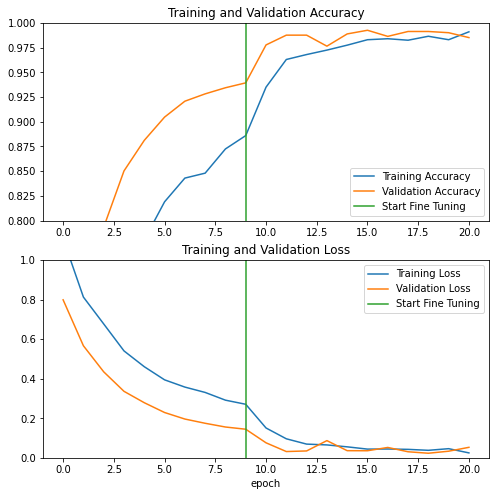

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(densenet_acc, label='Training Accuracy')
plt.plot(densenet_val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(densenet_loss, label='Training Loss')
plt.plot(densenet_val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
densenet_loss, densenet_accuracy = densenet_model.evaluate(test_dataset)
print('Test accuracy :', densenet_accuracy)

6/6 [==============================] - 1s 47ms/step - loss: 0.0707 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Predictions:
 [1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0]
Labels:
 [1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0]


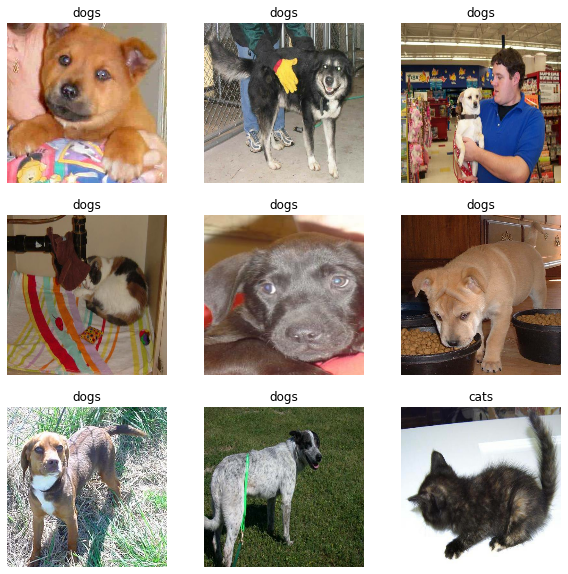

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = densenet_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Results Comparison (Densenet121 - MobileNetV2)

In [38]:
'''
1) Loss & Accuracy on Validation Data without training the model:
    MobileNetV2 -> loss: 0.7428 - accuracy: 0.5186
    Densenet121 -> loss: 0.8236 - accuracy: 0.5408

On the unseen data, without training the models, Densenet model is giving a good accuracy comparing to MobileNetV2

2) Loss, Accuracy, val_loss & val_accuracy after fitting the model on the training data at 10th epoch:
    MobileNetV2 -> loss: 0.2180 - accuracy: 0.9115 - val_loss: 0.1215 - val_accuracy: 0.9604
    Densenet121 -> loss: 0.2230 - accuracy: 0.8985 - val_loss: 0.1199 - val_accuracy: 0.943

After fitting the data to both models, MobileNetV2 is performing well on the training data and Validation dataset as well.
    
3) Loss, Accuracy, val_loss & val_accuracy after fine tuning the model on the training data at 20th epoch:
    MobileNetV2 -> loss: 0.0585 - accuracy: 0.9765 - val_loss: 0.0392 - val_accuracy: 0.9851
    Densenet121 -> loss: 0.0360 - accuracy: 0.9855 - val_loss: 0.0360 - val_accuracy: 0.9901

After fine tuning, Densenet is giving a slighly higher accuracy on validation dataset. 
Same for the training dataset, Densenet is performing slightly better than the MobileNetV2.
Also looking at the Accuracy-Loss curves of both models, it seems almost same. 


4) Loss and Accuracy on Test Data using final model:
    MobileNetV2 -> loss: 0.0281 - accuracy: 0.9948 
    Densenet121 -> loss: 0.0398 - accuracy: 0.9896
    
Even After giving a good results on training data in avobe steps, Densenet is giving a slightly less accuracy comparing 
to MobileNetV2 model.
And it can be observed from the fine tuning curves that Densenet is starting to perform a little off the track after
16th epoch.
The accuracy on the validation dataset is getting reduced and the loss is getting increase.

While on the other hand, MobileNetV2 is performing as desired after fine tuning.

Overall, both models' accuracy got boosted after the updating the weights, 
it boosted from 91% to 99% for Densenet121 and for MobileNetV2, boosted from 91% to 99.5%.
'''

"\n1) Loss & Accuracy on Validation Data without training the model:\n    MobileNetV2 -> loss: 0.7428 - accuracy: 0.5186\n    Densenet121 -> loss: 0.8236 - accuracy: 0.5408\n\nOn the unseen data, without training the models, Densenet model is giving a good accuracy comparing to MobileNetV2\n\n2) Loss, Accuracy, val_loss & val_accuracy after fitting the model on the training data at 10th epoch:\n    MobileNetV2 -> loss: 0.2180 - accuracy: 0.9115 - val_loss: 0.1215 - val_accuracy: 0.9604\n    Densenet121 -> loss: 0.2230 - accuracy: 0.8985 - val_loss: 0.1199 - val_accuracy: 0.943\n\nAfter fitting the data to both models, MobileNetV2 is performing well on the training data and Validation dataset as well.\n    \n3) Loss, Accuracy, val_loss & val_accuracy after fine tuning the model on the training data at 20th epoch:\n    MobileNetV2 -> loss: 0.0585 - accuracy: 0.9765 - val_loss: 0.0392 - val_accuracy: 0.9851\n    Densenet121 -> loss: 0.0360 - accuracy: 0.9855 - val_loss: 0.0360 - val_accur

## Xception on Cats & Dogs Dataset

### Rescaling the dataset & Creating the base model

In [39]:
# rescale pixel values
# xception.preprocess_input will scale input pixels between -1 and 1
xception_preprocess_input = tf.keras.applications.xception.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
xception_base = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)

83697664/83683744 [==============================] - 0s 0us/step


### Preparing the model

In [40]:
# feature extractor
image_batch, label_batch = next(iter(train_dataset))
xception_feature_batch = xception_base(image_batch)
print(xception_feature_batch.shape)

(32, 5, 5, 2048)


In [41]:
# freezing the convolutional base
xception_base.trainable = False

In [42]:
# Adding a classification head
xception_global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
xception_feature_batch_average = xception_global_average_layer(xception_feature_batch)
print(xception_feature_batch_average.shape)

(32, 2048)


In [43]:
xception_prediction_layer = tf.keras.layers.Dense(1)
xception_prediction_batch = xception_prediction_layer(xception_feature_batch_average)
print(xception_prediction_batch.shape)

(32, 1)


In [44]:
xception_inputs = tf.keras.Input(shape=(160, 160, 3))
xception_x = data_augmentation(xception_inputs)
xception_x = xception_preprocess_input(xception_x)
xception_x = xception_base(xception_x, training=False)
xception_x = xception_global_average_layer(xception_x)
xception_x = tf.keras.layers.Dropout(0.2)(xception_x)
xception_outputs = xception_prediction_layer(xception_x)
xception_model = tf.keras.Model(xception_inputs, xception_outputs)

### Compile the model - Xception

In [45]:
'''
Compile the model before training it. Since there are two classes,
use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.
'''
xception_base_learning_rate = 0.0001
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=xception_base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
xception_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [47]:
'''
Trainable parameters are divided between two tf.Variable objects, the weights and biases.
'''
len(xception_model.trainable_variables)

2

In [48]:
%%time
initial_epochs = 10

xception_loss0, xception_accuracy0 = xception_model.evaluate(validation_dataset)

26/26 [==============================] - 3s 48ms/step - loss: 0.7095 - accuracy: 0.5693
CPU times: user 3.4 s, sys: 157 ms, total: 3.55 s
Wall time: 2.94 s


In [49]:
%%time
xception_history = xception_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 80ms/step - loss: 0.5829 - accuracy: 0.6785 - val_loss: 0.4367 - val_accuracy: 0.7908
Epoch 2/10
63/63 [==============================] - 5s 71ms/step - loss: 0.4249 - accuracy: 0.7855 - val_loss: 0.3030 - val_accuracy: 0.8800
Epoch 3/10
63/63 [==============================] - 5s 71ms/step - loss: 0.3472 - accuracy: 0.8530 - val_loss: 0.2352 - val_accuracy: 0.9158
Epoch 4/10
63/63 [==============================] - 5s 70ms/step - loss: 0.2902 - accuracy: 0.8820 - val_loss: 0.1934 - val_accuracy: 0.9319
Epoch 5/10
63/63 [==============================] - 5s 71ms/step - loss: 0.2686 - accuracy: 0.8755 - val_loss: 0.1659 - val_accuracy: 0.9480
Epoch 6/10
63/63 [==============================] - 5s 79ms/step - loss: 0.2420 - accuracy: 0.9035 - val_loss: 0.1445 - val_accuracy: 0.9530
Epoch 7/10
63/63 [==============================] - 5s 71ms/step - loss: 0.2271 - accuracy: 0.9040 - val_loss: 0.1385 - val_accuracy: 0.9505
Epoch 8/10
63

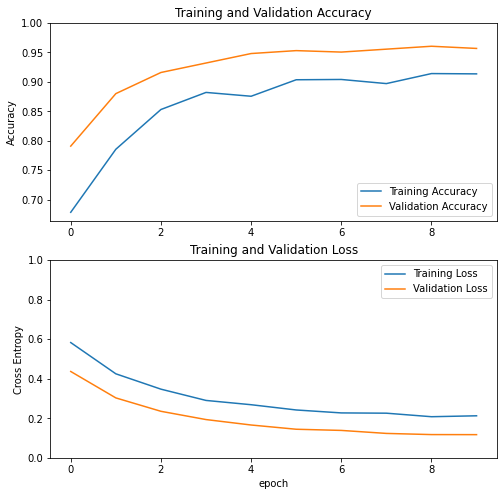

In [50]:
xception_acc = xception_history.history['accuracy']
xception_val_acc = xception_history.history['val_accuracy']

xception_loss = xception_history.history['loss']
xception_val_loss = xception_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(xception_acc, label='Training Accuracy')
plt.plot(xception_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(xception_loss, label='Training Loss')
plt.plot(xception_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
'''
All we need to do is unfreeze the base_model and set the bottom layers to be un-trainable.
Then, we should recompile the model (necessary for these changes to take effect), and resume training.
'''
xception_base.trainable = True

In [52]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(xception_base.layers))

# Fine-tune from this layer onwards
xception_fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in xception_base.layers[:xception_fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  132


In [53]:
xception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=xception_base_learning_rate/10),
              metrics=['accuracy'])

In [54]:
print(xception_model.summary())
print(len(xception_model.trainable_variables))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [55]:
%%time
# If we trained to convergence earlier, this step will improve your accuracy by a few percentage points.
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

xception_history_fine = xception_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=xception_history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 11s 109ms/step - loss: 0.1775 - accuracy: 0.9195 - val_loss: 0.0744 - val_accuracy: 0.9728
Epoch 11/20
63/63 [==============================] - 7s 99ms/step - loss: 0.1365 - accuracy: 0.9415 - val_loss: 0.0811 - val_accuracy: 0.9678
Epoch 12/20
63/63 [==============================] - 6s 99ms/step - loss: 0.1370 - accuracy: 0.9440 - val_loss: 0.0634 - val_accuracy: 0.9691
Epoch 13/20
63/63 [==============================] - 6s 98ms/step - loss: 0.1212 - accuracy: 0.9440 - val_loss: 0.0595 - val_accuracy: 0.9752
Epoch 14/20
63/63 [==============================] - 6s 97ms/step - loss: 0.1183 - accuracy: 0.9510 - val_loss: 0.0647 - val_accuracy: 0.9740
Epoch 15/20
63/63 [==============================] - 6s 97ms/step - loss: 0.1064 - accuracy: 0.9525 - val_loss: 0.0587 - val_accuracy: 0.9728
Epoch 16/20
63/63 [==============================] - 6s 98ms/step - loss: 0.0945 - accuracy: 0.9630 - val_loss: 0.0708 - val_accuracy: 0.9752
Epoc

In [56]:
xception_acc += xception_history_fine.history['accuracy']
xception_val_acc += xception_history_fine.history['val_accuracy']

xception_loss += xception_history_fine.history['loss']
xception_val_loss += xception_history_fine.history['val_loss']

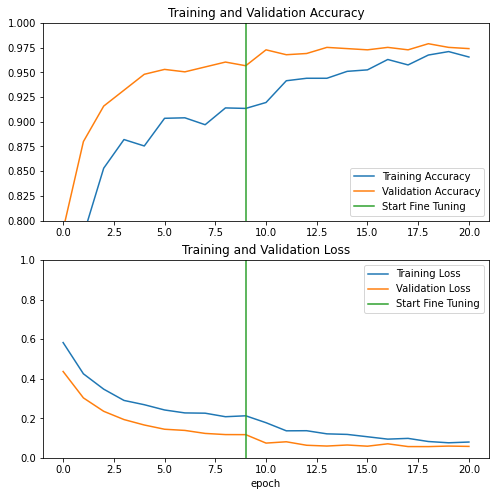

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(xception_acc, label='Training Accuracy')
plt.plot(xception_val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(xception_loss, label='Training Loss')
plt.plot(xception_val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
xception_loss, xception_accuracy = xception_model.evaluate(test_dataset)
print('Test accuracy :',xception_accuracy)

6/6 [==============================] - 1s 45ms/step - loss: 0.0348 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


### Results Comparison (Xception - MobileNetV2)

In [59]:
'''
1) Loss & Accuracy on Validation Data without training the model:
    MobileNetV2 -> loss: 0.7428 - accuracy: 0.5186
    Xception -> loss: 0.7777 - accuracy: 0.4814

On the unseen data, without training the models, MobileNetV2 model is giving a good accuracy comparing to Xception model.

2) Loss, Accuracy, val_loss & val_accuracy after fitting the model on the training data at 10th epoch:
    MobileNetV2 -> loss: 0.2180 - accuracy: 0.9115 - val_loss: 0.1215 - val_accuracy: 0.9604
    Xception -> loss: 0.2009 - accuracy: 0.9195 - val_loss: 0.1109 - val_accuracy: 0.9678

After fitting the data to both models, Xception is performing slightly better on the training and Validation dataset.
    
3) Loss, Accuracy, val_loss & val_accuracy after fine tuning the model on the training data at 20th epoch:
    MobileNetV2 -> loss: 0.0585 - accuracy: 0.9765 - val_loss: 0.0392 - val_accuracy: 0.9851
    Xception -> loss: 0.0784 - accuracy: 0.9645 - val_loss: 0.0478 - val_accuracy: 0.9802

After fine tuning, MobileNetV2 is giving a slighly higher accuracy on validation dataset. 
Same for the training dataset, MobileNetV2 is performing better than the Xception. 

4) Loss and Accuracy on Test Data using final model:
    MobileNetV2 -> loss: 0.0281 - accuracy: 0.9948 
    Xception -> loss: 0.0449 - accuracy: 0.9844
    
Both models are performing as desired from the above results. MobileNetV2 is performing well overall than Xception model.

Overall, both models' accuracy got boosted after the updating the weights, 
it boosted from 91% to 97.5% for Xception and for MobileNetV2, boosted from 91% to 99.5%.
'''

"\n1) Loss & Accuracy on Validation Data without training the model:\n    MobileNetV2 -> loss: 0.7428 - accuracy: 0.5186\n    Xception -> loss: 0.7777 - accuracy: 0.4814\n\nOn the unseen data, without training the models, MobileNetV2 model is giving a good accuracy comparing to Xception model.\n\n2) Loss, Accuracy, val_loss & val_accuracy after fitting the model on the training data at 10th epoch:\n    MobileNetV2 -> loss: 0.2180 - accuracy: 0.9115 - val_loss: 0.1215 - val_accuracy: 0.9604\n    Xception -> loss: 0.2009 - accuracy: 0.9195 - val_loss: 0.1109 - val_accuracy: 0.9678\n\nAfter fitting the data to both models, Xception is performing slightly better on the training and Validation dataset.\n    \n3) Loss, Accuracy, val_loss & val_accuracy after fine tuning the model on the training data at 20th epoch:\n    MobileNetV2 -> loss: 0.0585 - accuracy: 0.9765 - val_loss: 0.0392 - val_accuracy: 0.9851\n    Xception -> loss: 0.0784 - accuracy: 0.9645 - val_loss: 0.0478 - val_accuracy: 0